# 单个隐藏层用于平面数据分类

欢迎来到第三周的编程作业。现在是时候构建你的第一个神经网络了，它将有一个隐藏层。您将看到该模型与使用逻辑回归实现的模型之间的巨大差异。

**你将学习如何：**
- 实现一个具有单隐藏层的二分类神经网络
- 使用具有非线性激活功能的单元，如 $\tanh$
- 计算交叉熵损失
- 实现正向和反向传播


## 1 - 导入相关包 ##

让我们首先导入本次作业中需要的所有包。
- [numpy](www.numpy.org) 是 Python 中进行科学计算的基础包。
- [sklearn](http://scikit-learn.org/stable/) 提供简单高效的数据挖掘和数据分析工具。
- [matplotlib](http://matplotlib.org) 是 Python 中用于绘制图形的库。
- testCases 提供一些测试示例来评估你的函数的正确性
- planar_utils 提供了用于该赋值的各种有用函数

In [1]:
# 导入相关包
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # 设置随机数种子，使随机结果保持一致

## 2 - 数据集 ##

首先，让我们获取将要使用的数据集。下面的代码将一个 “flower” 二分类数据集加载到变量 `X` 和 `Y` 中。

In [2]:
X, Y = load_planar_dataset()

使用 matplotlib 可视化数据集。数据看起来像一朵 “花”，有一些红色（标签y=0）和一些蓝色（y=1）点。你的目标是建立一个模型来拟合这些数据。

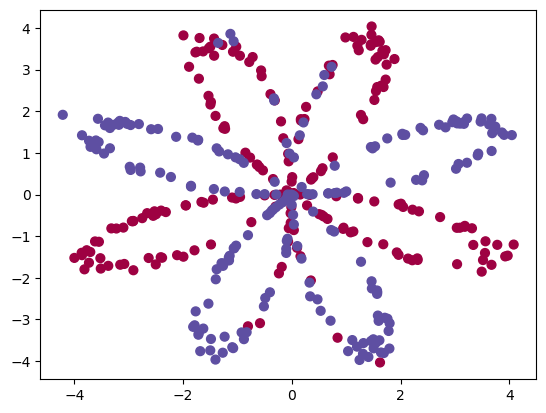

In [3]:
# 可视化数据:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()

你有：
- 一个包含特征 (x1, x2) 的 numpy 数组（矩阵）X
- 一个 numpy 数组（向量）Y，包含你的标签（red:0, blue:1）。

让我们首先更好地了解我们的数据是什么样子的。

**练习**：你有多少训练样本？另外，变量 `X` 和 `Y` 的 `shape` 是什么？

**提示**：如何获得 numpy 数组的形状？[(帮助)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.size # 训练集大小
### END CODE HERE ###

print ('X 的形状是: ' + str(shape_X))
print ('Y 的形状是: ' + str(shape_Y))
print ('我有 m = %d 个训练样本！' % (m))

X 的形状是: (2, 400)
Y 的形状是: (1, 400)
我有 m = 800 个训练样本！


**预期输出**：
       
<table style="width:20%">
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
  <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - 简单逻辑回归

在构建完整的神经网络之前，让我们先看看逻辑回归在这个问题上的表现。你可以使用 sklearn 的内置函数来做到这一点。运行下面的代码在数据集上训练一个逻辑回归分类器。

In [5]:
# 训练一个逻辑回归分类器
clf = sklearn.linear_model.LogisticRegressionCV()
# 使用 numpy 的 ravel() 方法来将 Y.T 转换为一个一维数组
clf.fit(X.T, Y.T.ravel())

LogisticRegressionCV()

现在可以绘制这些模型的决策边界了。运行下面的代码。

逻辑回归精度: 47 % (正确标记的数据点的百分比)


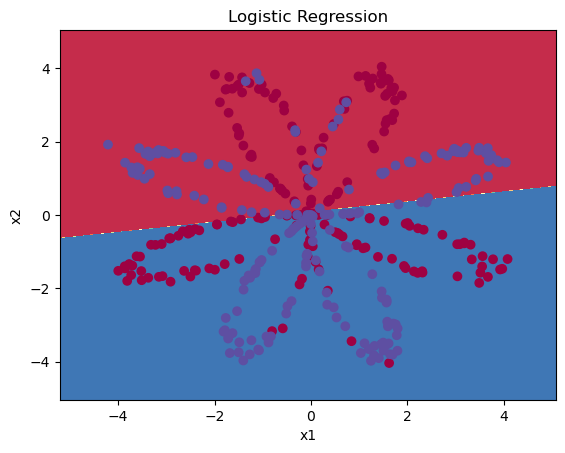

In [6]:
# 绘制逻辑回归的决策边界
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# 打印精度
LR_predictions = clf.predict(X.T)
# 使用 numpy 的 mean() 方法计算这个数组中所有元素的平均值
LR_accurary = np.mean((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100)
print ('逻辑回归精度: %d ' %(LR_accurary) + '% ' + "(正确标记的数据点的百分比)")

**预期输出**：

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
</table>


**解释**：数据集是不可线性分离的，因此逻辑回归表现不佳。希望神经网络能做得更好。让我们现在试试！

## 4 - 神经网络模型

逻辑回归在 “flower数据集” 上效果不佳。下面你将训练一个只有一层隐藏层的神经网络。

**这是你的模型结构**：

<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**数学表达**：

对于单个样本 $x^{(i)}$：

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$
y^{(i)}_{prediction} = \begin{cases}
1 & \text{if }\ a^{[2](i)} > 0.5 \\
0 & \text{otherwise }
\end{cases}\tag{5}
$$

给定所有示例的预测，您还可以计算成本 $J$：

$$
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}
$$

**提醒**： 构建神经网络的一般方法是：
1. 定义神经网络结构（#输入单元，#隐藏单元，等等）
2. 初始化模型的参数
3. 循环：
   - 实现正向传播计算出单个预测值
   - 计算单个样本的损失函数
   - 实现反向传播来获取梯度
   - 更新参数（梯度下降）

我们会经常构建辅助函数来计算步骤 1-3，然后将它们合并到一个函数中，我们称之为 `nn_model()`。一旦你构建了 `nn_model()` 并学习了正确的参数，你就可以对新数据进行预测。

### 4.1 - 定义神经网络结构 ####

**练习**：定义三个变量：
- `n_x`：输入层的大小
- `n_h`：隐藏层的大小（设置为 4）
- `n_y`：输出层的大小

**提示**：使用 `X` 和 `Y` 的形状来找到 `n_x` 和 `n_y`。此外，将隐藏层的大小硬编码（就是直接赋值）为 4。

In [7]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- 输入数据集的形状（输入大小，样本数量）
    Y -- 生成标签数据的形状（输出大小，样本数量）
    
    Returns:
    n_x -- 输入层的大小
    n_h -- 隐藏层的大小
    n_y -- 输出层的大小
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("输入层的大小: n_x = " + str(n_x))
print("隐藏层的大小: n_h = " + str(n_h))
print("输出层的大小: n_y = " + str(n_y))

输入层的大小: n_x = 5
隐藏层的大小: n_h = 4
输出层的大小: n_y = 2


**预期输出**：（这些大小并不是将要使用于网络的大小，它们只是用于评估刚刚编写的功能）。
<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - 初始化模型参数 ####

**练习**：实现函数 `initialize_parameters()`。

**指导**：
- 确保你的参数大小正确。如果需要，请参考上面的神经网络图。
- 用随机值初始化权重矩阵。
    - 使用：`np.random.randn(a,b) * 0.01` 来随机初始化形状为 (a,b) 的矩阵。
- 将偏差向量初始化为零。
    - 使用：`np.zeros((a,b))` 来初始化一个形状为 (a,b) 的零矩阵。

In [9]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- 输入层的大小
    n_h -- 隐藏层的大小
    n_y -- 输出层的大小
    
    Returns:
    params -- 包含相关参数的 Python 字典:
                    W1 -- 形状为 (n_h, n_x) 的权重矩阵
                    b1 -- 形状为 (n_h, 1) 的偏差矩阵
                    W2 -- 形状为 (n_y, n_h) 的权重矩阵
                    b2 -- 形状为 (n_y, 1) 的偏差矩阵
    """
    
    np.random.seed(2) # 虽然初始化是随机的，但我们设置了一个种子，以便您的输出与我们的匹配。
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = 
[[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = 
[[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**预期输出**：

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - 循环 ###


#### 4.3.1 - 前向传播

**问题**：实现 `forward_propagation()`。

**指导**：
- 查看上面分类器的数学表示。
- 你可以使用函数 `sigmoid()`。它是内置（预先导入）在 notebook 中。
- 你可以使用函数 `np.tanh()`。它是 numpy 库的一部分。
- 你必须执行的步骤是：
  1. 使用 `parameters[".."]` 从字典 `parameters`（它是 `initialize_parameters()` 的输出）中检索每个参数。

  2. 实现正向传播，计算 $Z^{[1]}， A^{[1]}， Z^{[2]}$ 和 $A^{[2]}$（训练集中所有样本的所有预测的向量）。
- 反向传播中需要的值存储在 `cache` 中。`cache` 将作为反向传播函数的输入。

In [11]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- 大小为 (n_x, m) 的输入数据
    parameters -- 包含参数的 Python 字典 (initialize_parameters() 初始化函数的输出)
    
    Returns:
    A2 -- 第二个激活函数的 sigmoid 输出
    cache -- 一个包含 "Z1", "A1", "Z2" 以及 "A2" 的字典
    """
    # 从字典 "parameters" 中检索每个参数
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # 实现正向传播来计算 A2 (概率)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# 注意：在这里我们使用平均值只是为了确保你的输出与我们的匹配。
print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


**预期输出**：
<table style="width:55%">
  <tr>
    <td> -0.000499755777742 -0.000496963353232 0.000438187450959 0.500109546852 </td> 
  </tr>
</table>

现在你已经计算出了 $A^{[2]}$（在 Python 变量" ' A2 ' "中），其中包含了每个样本的 $A^{[2] (i)}$，你可以像下面这样计算成本函数：

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{[} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{]} \small\tag{13}$$

**练习**： 实现 `compute_cost()` 去计算成本值 $J$

**指导**：
- 有许多方法可以实现交叉熵损失。为了帮助你，我们告诉你我们将如何实施

$$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$$

```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # 不需要使用 for 循环
```

（你可以使用 `np.multiply()` 和 `np.sum()`，或者直接使用 `np.dot()`）。

In [13]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    计算公式(13)中的交叉熵代价
    
    Arguments:
    A2 -- 第二个激活函数 sigmoid 的输出, 形状为 (1, 样本数量)
    Y -- "true" 标记, 形状为 (1, 样本数量) 的向量
    parameters -- python字典, 包含参数 W1、b1、W2 和 b2
    
    Returns:
    cost -- 公式(13)计算的交叉熵代价
    """
    
    m = Y.shape[1] # 样本数量

    # 计算交叉熵代价
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), (1-Y))
    cost = -1 / m * np.sum(logprobs)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # 确保成本符合我们的预期
                                # E.g., 把 [[17]] 变成 17
    assert(isinstance(cost, float))
    
    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761265


**预期输出**：
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.692919893776 </td> 
  </tr>
  
</table>

#### 4.3.2 - 后向传播

使用在正向传播过程中计算的缓存，您现在可以实现反向传播。

**问题**：实现函数 `backward_propagation()`

**指导**：
反向传播通常是深度学习中最难的（最数学的）部分。为了帮助你们，这里有一张关于反向传播的幻灯片。你会想要使用这张幻灯片右边的六个方程，因为你正在构建一个矢量化的实现。  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

**Tips:**
  - 为了计算 $dZ^{[1]}$ 你要先计算 $g^{[1]'}(Z^{[1]})$。因为 $g ^{[1]}()$ 是双曲正切激活函数，若 $a=g^{[1]}(z)$，则 $g ^{[1]'}(z)=1-a^2$，所以你可以使用 `(1 - np.power(A1, 2))` 去计算 $g^{[1]'}(Z^{[1]})$

In [15]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    使用上面的指令实现反向传播。
    
    Arguments:
    parameters -- 包含我们参数的 Python 字典
    cache -- 一个包含 "Z1", "A1", "Z2" 以及 "A2" 的字典
    X -- 形状为 (2, 样本数量) 的输入数据
    Y -- 形状为 (1, 样本数量) 的向量 "true" 标记
    
    Returns:
    grads -- Python字典, 包含不同参数下的梯度
    """
    m = X.shape[1]
    
    # 首先，从字典 "parameters" 中检索 W1 和 W2。
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # 再从字典 "cache" 中检索 A1 和 A2。
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # 后向传播：计算 dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, 对应上面幻灯片上的 6 个方程)
    dZ2 = A2 - Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1 / m * np.dot(dZ1, X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("db1 = \n"+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = 
[[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = 
[[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


**预期输出**：



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]] </td> 
  </tr>
  <tr>
    <td>**db1**</td>
    <td>  [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]] </td> 
  </tr>
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00363613  0.03153604  0.01162914 -0.01318316]] </td> 
  </tr>
  <tr>
    <td>**db2**</td>
    <td> [[ 0.06589489]] </td> 
  </tr>
  
</table>  

#### 4.3.3 - 梯度下降

**问题**：使用梯度下降法实现更新规则，必须使用 (dW1、db1、dW2、db2) 才能更新 (W1、b1、W2、b2)。

**一般梯度下降法则**： $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ 这里的 $\alpha$ 是指学习率，$\theta$ 表示参数。

**图解**：梯度下降算法在良好的学习率（收敛）和糟糕的学习率（发散）上的表现。图片由 Adam Harley 提供。

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [17]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 0.2):
    """
    使用上述梯度下降更新规则更新参数
    
    Arguments:
    parameters -- 包含参数的 Python 字典 
    grads -- 包含梯度的 Python 字典
    
    Returns:
    parameters -- 包含更新后的参数的 Python 字典
    """
    # 从字典 "parameters" 中检索每个参数
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # 从字典 "grads" 中检索每个梯度
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # 更新每个参数的规则
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = 
[[-0.00619703  0.01731295]
 [-0.02328236  0.03277276]
 [-0.01685804 -0.01809817]
 [ 0.00954007 -0.05180208]]
b1 = 
[[-9.18637472e-07]
 [ 8.91924989e-06]
 [ 6.42841662e-07]
 [-2.65490056e-06]]
W2 = [[-0.01042839 -0.04093053  0.01632348  0.04491398]]
b2 = [[9.36739006e-05]]


**预期输出**：


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - 在 `nn_model()` 中集成第 4.1、4.2、4.3 节 ####

**问题**： 在 `nn_model()` 中创建你的神经网络模型

**指导**：神经网络模型必须按照正确的顺序使用前面的函数。

In [19]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- 形状为 (2, 样本数量) 的数据集
    Y -- 形状为 (1, 样本数量) 的标签
    n_h -- 隐藏层大小
    num_iterations -- 梯度下降循环的迭代次数
    print_cost -- 如果为 True, 则每 1000 次迭代打印一次 cost
    
    Returns:
    parameters -- 模型学习到的参数, 然后可以用它们来预测。
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # 初始化参数, 然后检索 W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # 循环 (梯度下降)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # 前向传播. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost 函数. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
        # 后向传播. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        # 梯度下降参数更新. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        ### END CODE HERE ###
        
        # 每 1000 次迭代打印一次 cost
        if print_cost and i % 1000 == 0:
            print ("%i 次迭代后的 cost: %f" %(i, cost))
        
    return parameters

In [20]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

0 次迭代后的 cost: 0.692584
1000 次迭代后的 cost: -inf
2000 次迭代后的 cost: -inf
3000 次迭代后的 cost: -inf
4000 次迭代后的 cost: -inf


C:\Users\Evolto\AppData\Local\Temp\ipykernel_26176\2113419177.py:20: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), (1-Y))
e:\github\self-website\AI-study\code\CS230\1-Neural-Networks-and-Deep-Learning\planar_utils.py:34: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


5000 次迭代后的 cost: -inf
6000 次迭代后的 cost: -inf
7000 次迭代后的 cost: -inf
8000 次迭代后的 cost: -inf
9000 次迭代后的 cost: -inf
W1 = 
[[-3.61101161  4.17787395]
 [-6.0008406   1.15289364]
 [-3.59380601  4.18559334]
 [ 6.0008003  -1.15288967]]
b1 = 
[[ 1.88797475]
 [ 3.01407696]
 [ 1.89149187]
 [-3.01406492]]
W2 = [[-1003.66386129 -1000.54020231 -1002.842084    1000.49371067]]
b2 = [[-9.42486178]]


**预期输出**：

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-4.18494056  5.33220609]
 [-7.52989382  1.24306181]
 [-4.1929459   5.32632331]
 [ 7.52983719 -1.24309422]]</td> 
  </tr>
  <tr>
    <td>**b1**</td>
    <td> [[ 2.32926819]
 [ 3.79458998]
 [ 2.33002577]
 [-3.79468846]]</td> 
  </tr>
  <tr>
    <td>**W2**</td>
    <td> [[-6033.83672146 -6008.12980822 -6033.10095287  6008.06637269]] </td> 
  </tr>
  <tr>
    <td>**b2**</td>
    <td> [[-52.66607724]] </td> 
  </tr>
  
</table>  

### 4.5 预测

**问题**：通过构建 predict() 来使用你的模型进行预测。使用前向传播来预测结果。


**提示**：  $\text{predictions} =y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
举个例子，如果你想根据阈值将矩阵 X 中的元素设置为 0 和 1，可以这样做： ```X_new = (X > threshold)```

In [21]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    使用学习到的参数, 预测 X 中每个样本的类别
    
    Arguments:
    parameters -- 包含参数的 Python 字典
    X -- 大小为 (n_x, m) 的数据
    
    Returns
    predictions -- 我们模型的预测向量 (red: 0 / blue: 1)
    """
    
    # 使用正向传播计算概率，并以 0.5 为阈值分类到 0/1。
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    ### END CODE HERE ###
    
    return predictions

In [22]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


**预期输出**： 

<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

是时候运行模型了，看看它在平面数据集上的表现如何。运行以下代码以测试具有 $n_h$ 个隐藏单元的单个隐藏层的模型。

0 次迭代后的 cost: 0.693048
1000 次迭代后的 cost: 0.361253
2000 次迭代后的 cost: 0.316968
3000 次迭代后的 cost: 0.304688
4000 次迭代后的 cost: 0.297613
5000 次迭代后的 cost: 0.292528
6000 次迭代后的 cost: 0.288462


7000 次迭代后的 cost: 0.285035
8000 次迭代后的 cost: 0.282065
9000 次迭代后的 cost: 0.279433


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

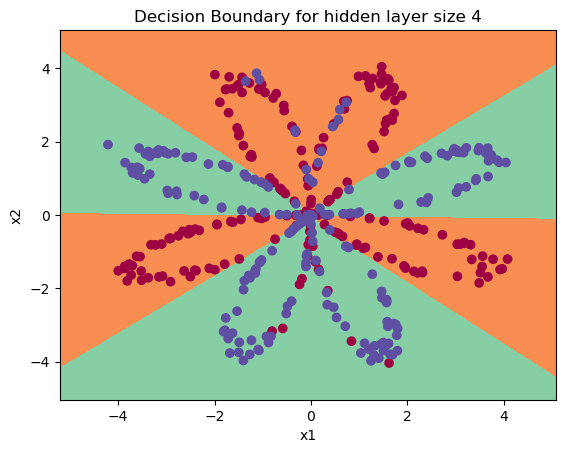

In [23]:
# 构建一个 n_h 维隐藏层的模型
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# 绘制决策边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

**预期输出**：

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [24]:
# 打印精度
predictions = predict(parameters, X)
predictions_accuracy = np.mean((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
print ('精度: %d' %(predictions_accuracy) + '%')

精度: 89%


**预期输出**： 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

与逻辑回归相比，准确率很高。模型已经学会了花朵的叶子图案！与逻辑回归不同，神经网络甚至能够学习高度非线性的决策边界。

现在，让我们尝试几种隐藏层的大小。

### 4.6 -调整隐藏层大小（可选/无等级练习） ###

运行下面的代码。可能需要 1-2 分钟。你可以观察到不同隐藏层大小的模型的不同行为。

隐藏层中有 1 个隐藏单元的精度: 67.75 %
隐藏层中有 2 个隐藏单元的精度: 65.0 %
隐藏层中有 3 个隐藏单元的精度: 89.75 %
隐藏层中有 4 个隐藏单元的精度: 89.25 %
隐藏层中有 5 个隐藏单元的精度: 88.75 %
隐藏层中有 20 个隐藏单元的精度: 87.75 %
隐藏层中有 50 个隐藏单元的精度: 87.75 %


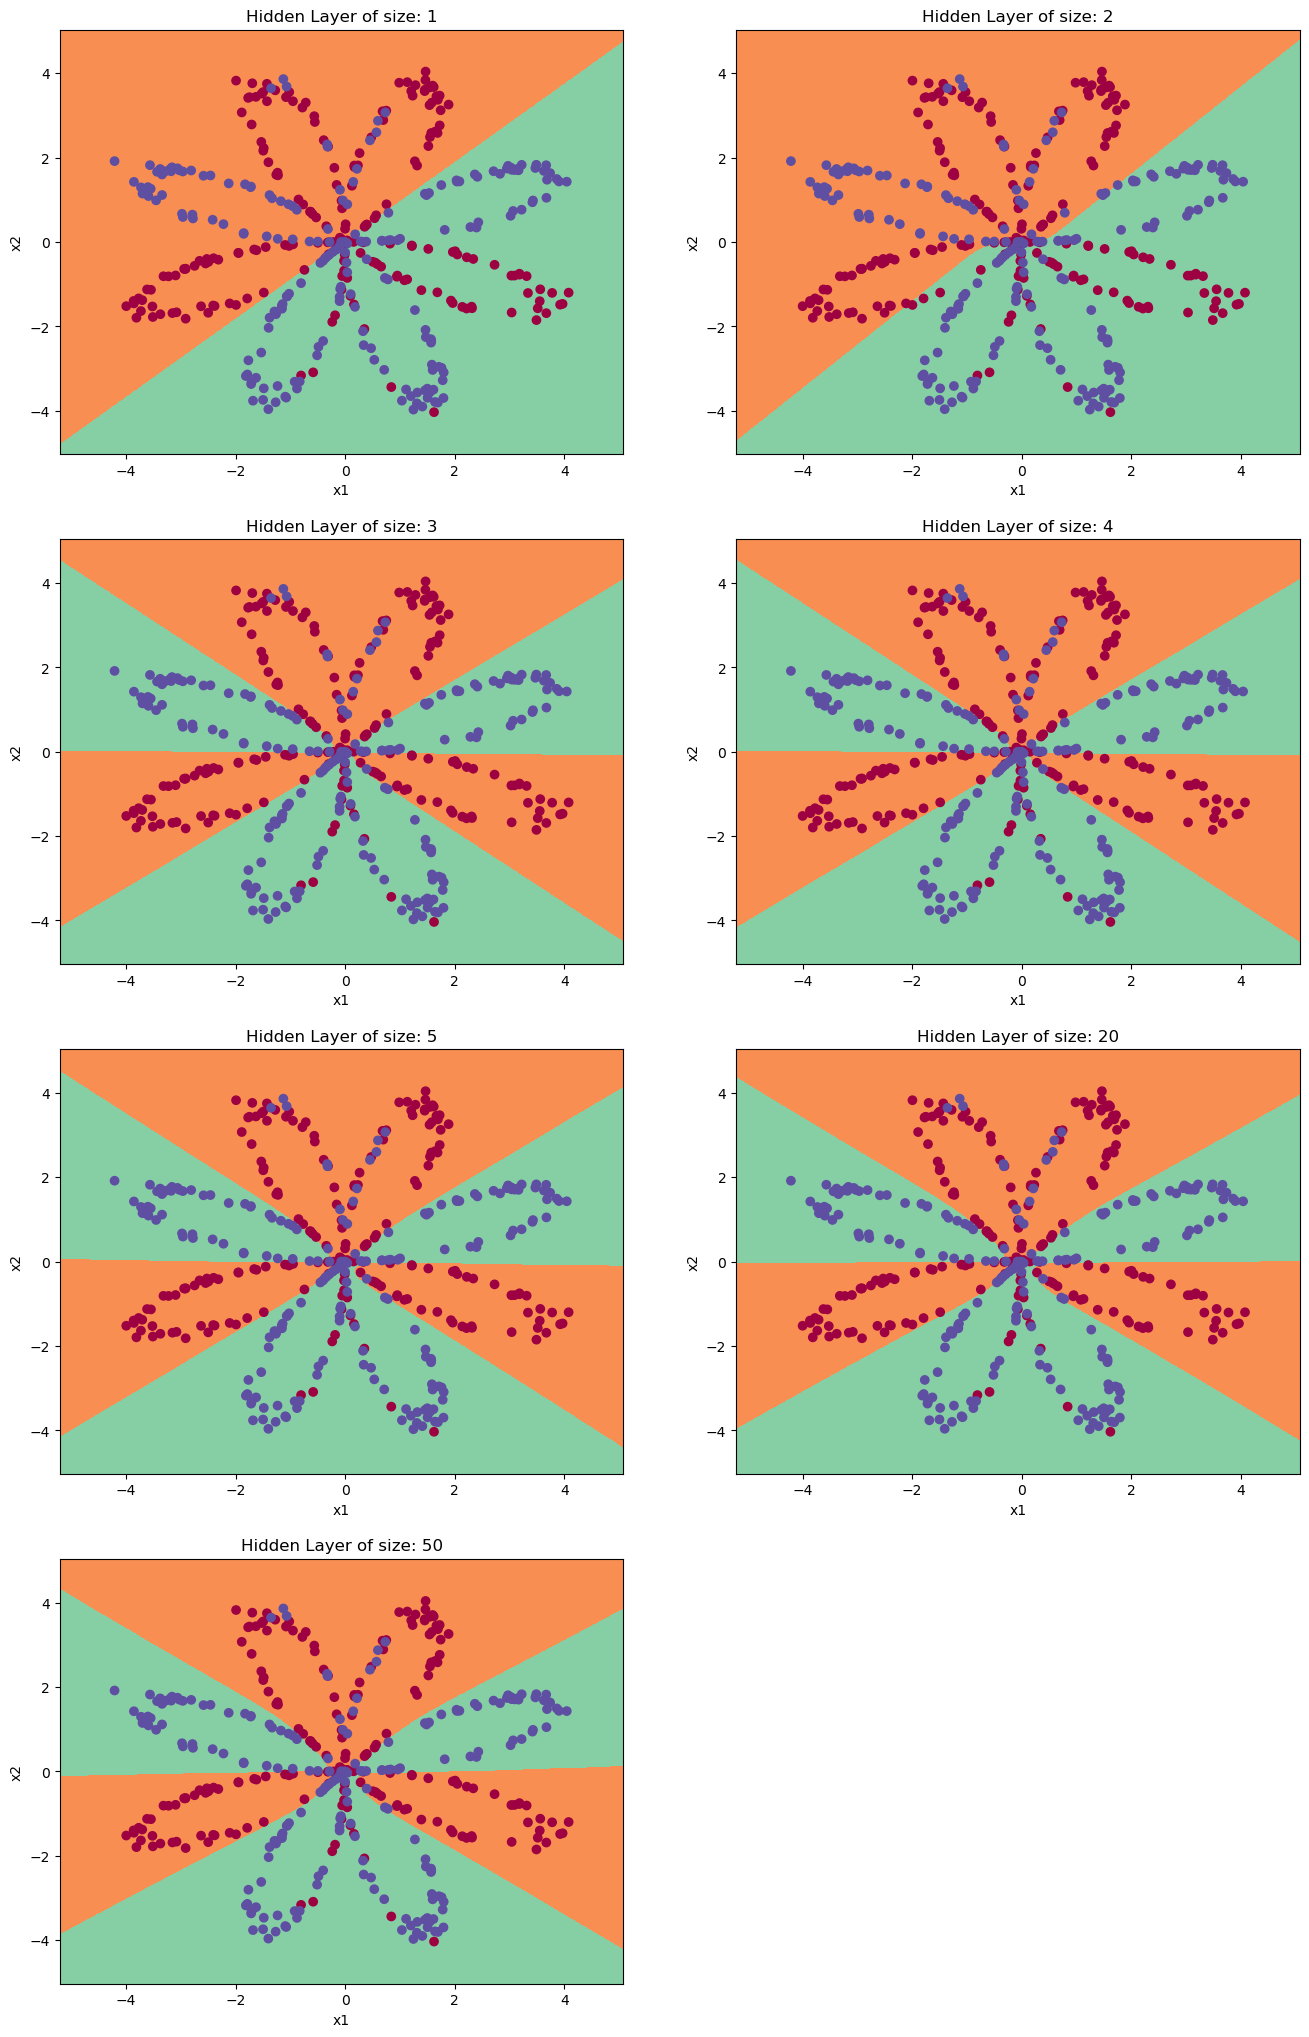

In [25]:
# 这可能需要 2 分钟的运行时间

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size: %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = np.mean((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("隐藏层中有 {} 个隐藏单元的精度: {} %".format(n_h, accuracy))

**指导**：
- 更大的模型（具有更多的隐藏单元）能够更好地拟合训练集，直到最终最大的模型过度拟合数据。
- 最佳的隐藏层大小似乎在 $n_h = 5$ 左右。实际上，这里的值似乎可以很好地拟合数据，而不会引起明显的过拟合。
- 后面你还将学习正则化，它允许你使用非常大的模型（例如 $n_h = 50$），而不会出现过度拟合。

**可选的问题**：

如果你愿意，你可以探索一些可选/未评分的问题：
- 当你将激活函数从 tanh 改为 sigmoid 或 ReLU 函数时会发生什么?
- 调整一下 learning_rate 学习率，会发生什么？
- 如果我们改变数据集呢？（参见下面的第 5 部分！）

<font color='blue'>

**你已经学会了**：
- 使用隐藏层构建一个完整的神经网络
- 充分利用非线性单元
- 实现正向传播和反向传播，并训练神经网络
- 查看改变隐藏层大小的影响，包括过拟合。

## 5 在其他数据集上的性能

如果你愿意，可以对下面的数据集重新运行整个 notebook（除去数据集部分）。

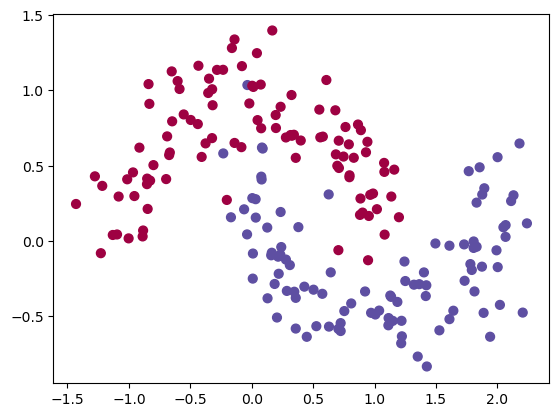

In [26]:
# 加载数据集
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (选择你的数据集)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# 把 blob 变成二进制
if dataset == "noisy_moons":
    Y = Y%2

# 可视化数据
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

恭喜你完成了这个编程作业！

参考：
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/